## Compute the features from all layers and check.

1. https://keras.io/api/applications/#vgg19
2. Make the computation a bit modular.
3. Plot the TCAV scores with features from all layers.

### Layers in VGG19

1. Conv3x3 (64), Conv3x3 (64), MaxPool
2. Conv3x3 (128), Conv3x3 (128), MaxPool
3. Conv3x3 (256), Conv3x3 (256), Conv3x3 (256), Conv3x3 (256), MaxPool
4. Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), MaxPool
5. Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), Conv3x3 (512), MaxPool
6. FC + Softmax (we remove this, since include_top = False)

In [281]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import concurrent.futures
from matplotlib import pyplot as plt
%matplotlib inline

In [284]:
class ModelInstantiate:
    def __init__(self, layer, mode):
        self.layer = layer
        self.mode = mode
        
    def get_model(self):
        if self.mode == 'VGG19':
            base_model = VGG19(weights='imagenet', include_top=False)
        else:
            base_model = VGG16(weights='imagenet', include_top=False)
        model = Model(inputs=base_model.input, outputs=base_model.get_layer(self.layer).output)
        return model
    
    def _get_features(self, img):
        model = self.get_model()
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        fts = model.predict(img_data)
        fts_np = np.array(fts)
        return fts_np #np.squeeze(fts_np)

In [260]:
class ImageReader:
    def __init__(self, classes, folderpath, label_dict):
        self.classes = classes
        self.folderpath = folderpath
        self.label_dict = label_dict
        self.images = []
        self.labels = []
        
    def read_images(self):
        for base in self.classes:
            for ix, imgp in tqdm(enumerate(glob(self.folderpath + base + '/*.jpg'))):
                label = imgp.split('/')[-2]
                img = cv2.imread(imgp)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224,224))
                self.images.append(img)
                self.labels.append(self.label_dict[label])
    
    def get_images_and_labels(self):
        self.read_images()
        return self.images, self.labels

In [261]:
#layers = ["block1_pool", "block2_pool", "block3_pool", "block4_pool", "block5_pool"]
layers = ["block5_pool"]
modes = ["VGG16", "VGG19"]
classes = ["zebra", "tiger"]
classes_dict = {"zebra": 1, "tiger": 0}
concepts = ["zebra_stripes", "tiger_stripes"]
concepts_dict = {"zebra_stripes": 1, "tiger_stripes": 0}
folderpath = "/Users/Janjua/Desktop/QCRI/Work/zebra_stripes_data/"

reader_base = ImageReader(classes, folderpath, classes_dict)
reader_concept = ImageReader(concepts, folderpath, concepts_dict)

In [262]:
concept_imgs, concept_labels = reader_concept.get_images_and_labels()

79it [00:00, 670.54it/s]
79it [00:00, 661.56it/s]


In [263]:
print('Reading data for both - Zebra and Tiger!')
zebra_reader_base = ImageReader([classes[0]], folderpath, classes_dict)
tiger_reader_base = ImageReader([classes[1]], folderpath, classes_dict)

zebra_imgs, zebra_labels = zebra_reader_base.get_images_and_labels()
tiger_imgs, tiger_labels = tiger_reader_base.get_images_and_labels()

79it [00:00, 666.26it/s]
0it [00:00, ?it/s]

Reading data for both - Zebra and Tiger!


79it [00:00, 661.26it/s]


In [247]:
print(len(concept_imgs), len(zebra_imgs), len(concept_labels))
print(len(tiger_imgs))

158 79 158
79


In [248]:
concept_fts_dict_VGG16 = {
                    "block1_pool": [],
                    "block2_pool": [],
                    "block3_pool": [],
                    "block4_pool": [],
                    "block5_pool": [],
                    "block1_conv1": [],
                    "block2_conv1": [],
                    "block1_conv2": [],
                    "block2_conv2": [],
                    "block3_conv1": [],
                    "block4_conv1": [],
                    "block3_conv2": [],
                    "block4_conv2": [],
                    "block5_conv2": [],
                    "block5_conv3": []
                 }

zebra_fts_dict_VGG16 = {
                    "block1_pool": [],
                    "block2_pool": [],
                    "block3_pool": [],
                    "block4_pool": [],
                    "block5_pool": [],
                    "block1_conv1": [],
                    "block2_conv1": [],
                    "block1_conv2": [],
                    "block2_conv2": [],
                    "block3_conv1": [],
                    "block4_conv1": [],
                    "block3_conv2": [],
                    "block4_conv2": [],
                    "block5_conv2": [],
                    "block5_conv3": []
                 }

print('Go get coffee - this takes some time.')

with concurrent.futures.ProcessPoolExecutor() as executor:    
    for layer in layers:
        model_instance =  ModelInstantiate(layer, modes[0])
        print('Running for layer # ', layer)

        for ix, val in tqdm(enumerate(concept_imgs)):
            fts_1 = executor.submit(model_instance._get_features, val)
            concept_fts_dict_VGG16[layer].append(fts_1.result())

        for ix, val in tqdm(enumerate(zebra_imgs)):
            fts_2 = executor.submit(model_instance._get_features, val)
            zebra_fts_dict_VGG16[layer].append(fts_2.result()) 

0it [00:00, ?it/s]

Go get coffee - this takes some time.
Running for layer #  block2_pool
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


1it [00:00,  1.09it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2it [00:01,  1.10it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


3it [00:02,  1.14it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


4it [00:03,  1.18it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


5it [00:04,  1.20it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


6it [00:04,  1.22it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


7it [00:05,  1.24it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


158it [03:30,  1.33s/it]
79it [03:12,  2.43s/it]
0it [00:00, ?it/s]

Running for layer #  block5_pool


158it [09:15,  3.51s/it]
79it [05:36,  4.26s/it]


In [249]:
no_concepts = 158
no_imgs = 79
lbls_np = np.array(concept_labels)
clf = LogisticRegression(random_state=0)
#clf = ElasticNet(random_state=0, l1_ratio=0.0001)
#clf = LinearSVC(random_state=0, tol=1e-5)
concept_cavs = {
                    "block1_pool": [],
                    "block2_pool": [],
                    "block3_pool": [],
                    "block4_pool": [],
                    "block5_pool": [],
                    "block1_conv1": [],
                    "block2_conv1": [],
                    "block1_conv2": [],
                    "block2_conv2": [],
                    "block3_conv1": [],
                    "block4_conv1": [],
                    "block3_conv2": [],
                    "block4_conv2": [],
                    "block5_conv2": [],
                    "block5_conv3": []
                 }

for key, value in concept_fts_dict_VGG16.items():
    if len(value) > 0:
        print("For layer # - ", key)
        fts_np = np.array(value)
        fts_np = fts_np.reshape(no_concepts, -1)
        clf.fit(fts_np, lbls_np)
        # compute CAVs
        print(len(clf.coef_))
        if len(clf.coef_) == 1:
            cavs = [-1 * clf.coef_[0], clf.coef_[0]]
        else:
            cavs = [c for c in clf.coef_]
        concept_cavs[key].append(cavs)

For layer # -  block2_pool


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1
For layer # -  block5_pool
1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [250]:
# since we have CAVs all computed, now we have to compute TCAV.
def get_direction(layer, concept):
    cavs = concept_cavs[layer][0] # since it is a list of lists
    return cavs[concepts.index(concept)]

def compute_direc_derivative(x, y):
    a = np.dot(x, y)
    return a < 0

In [311]:
one_img = zebra_fts_dict_VGG16['block5_pool'][0].shape
cav = get_direction('block5_pool', 'zebra_stripes')

for ix, weight in enumerate(cav):
    if abs(weight) > 0:
        print([ix], weight)

[0] 0.0017790194249693865
[1] -3.5215972423808635e-07
[2] 7.818919811443614e-06
[4] -0.0017496586903105928
[5] -2.912606496561752e-06
[6] -0.00010769215729689622
[7] 1.8594350697417394e-05
[8] -7.403435213097743e-05
[9] -4.4078380450288766e-05
[10] 9.290307364113827e-06
[11] 1.8153504256526096e-05
[12] -0.0006594774091214649
[14] 4.050723195511581e-05
[15] 0.0005083334357052585
[16] 0.0006088960451813752
[17] 0.0010191064761902345
[18] 3.150369641203546e-05
[19] 0.0018904527178485958
[20] 0.00023595721733332082
[21] 0.00023528715087881914
[22] 0.0002085981448083023
[23] 0.0005487169275815345
[24] 3.954444206877473e-06
[25] 0.005821046728322887
[26] 0.0004517003310013898
[27] 0.0003525107425639089
[28] -0.000644752601923416
[29] 4.9728496273411745e-06
[30] 7.830527832744679e-05
[31] -0.000978487327909188
[32] -0.00012572443192412577
[33] 0.00010381587669925637
[34] 0.0014225911487193556
[35] 0.0003396250305313743
[36] 0.00019194043434654715
[37] 0.0002151761365029553
[38] -0.00063416957

[958] 0.0004978367188262162
[959] 8.018862814458372e-05
[960] 0.00022695185057607797
[961] 0.00015281549474874771
[962] -1.7315631198908295e-05
[963] -0.00046854851202225326
[964] 0.0004465166089346243
[965] 0.00020779091772834456
[966] 0.0012052237559007667
[967] 0.0001312504304751989
[968] 0.0007217714604696398
[969] 2.9462825812898506e-05
[970] 0.0013054056552929717
[971] -4.787896708268559e-06
[972] 0.0002843224792438948
[973] -0.0007640801714763564
[974] -3.291895485808022e-06
[975] -0.0003438671648736346
[976] 0.00034752107451226614
[977] -0.000529127584400807
[978] 0.00013799760101639822
[979] 0.000837838954786967
[980] -0.0003293176879835481
[981] -0.0029277713843596843
[982] -0.00033894412601793853
[983] -0.0013425572366434115
[984] 6.290024698093761e-05
[985] 2.9489791566617393e-05
[986] -0.00075162762014383
[987] 1.528805521596723e-07
[988] -0.00019673315153887134
[989] 0.00033502057943421735
[990] 8.851748281150785e-05
[991] 5.5166944100101014e-05
[992] 0.000405100795157451

[1726] 0.0002228446312174962
[1727] 0.000366314151903971
[1728] 9.256651639139517e-06
[1729] -1.6672497847558177e-05
[1730] 0.0013958755175651199
[1731] 0.0001683144572091938
[1732] 0.0001810448654686535
[1733] 1.3590615292936258e-05
[1734] 0.00012443304385139248
[1735] 0.0007781707769870451
[1736] 5.357067204742782e-06
[1737] 0.00020761858124327098
[1738] 0.00018861487544497057
[1739] -0.00040885633491216634
[1740] -0.0005033074934501187
[1741] 0.00040457529219719055
[1742] -1.3525546572505709e-05
[1743] 0.0011078999168099772
[1744] 8.310058179790643e-05
[1745] 0.0011454843460545865
[1746] -7.798637027631507e-05
[1747] -1.0474818792541725e-05
[1748] -0.0005386609775639
[1749] -0.00019445340914918914
[1750] -8.6019246359487e-05
[1751] -0.00039185152683608997
[1752] 0.0001499183349283652
[1753] 0.00011714010247423348
[1754] 0.00012864715483743765
[1755] -0.0002847066609382904
[1756] 8.116237352927513e-05
[1757] -6.77501141960265e-06
[1758] 3.392653678424991e-05
[1759] 0.0002342180406815

[2242] 0.00016083579623672248
[2243] 0.00012072758117115689
[2244] 0.00033286493538591785
[2246] 5.9348672898803526e-05
[2247] 0.0005839722980635173
[2248] 0.00034283495721234853
[2249] 0.00023925417168962326
[2250] 0.0002155335655836893
[2251] 2.0150608749070746e-05
[2252] -0.00042238625576479066
[2253] 0.0007330211093272685
[2254] 0.00011485788572323637
[2255] 0.0006965677358169122
[2256] 9.26083994539525e-05
[2257] 0.000210419238268086
[2258] -0.00011814476895001121
[2259] -2.075253233027062e-06
[2260] -9.018319437959508e-05
[2261] -5.531762318380132e-05
[2262] 0.0012732084581666668
[2263] -0.0005919108005349389
[2264] 0.00015273058566092696
[2265] 0.00022068411710065788
[2266] 0.0009149303203026539
[2267] -9.472263042841861e-05
[2269] 5.508377539052981e-05
[2270] 4.302227180040701e-05
[2271] 4.485274000268575e-05
[2272] -2.4448502216541066e-05
[2273] 0.00031301530131123024
[2274] 0.0033527246163230933
[2275] -0.0004210788526372768
[2276] -0.0005521898975961062
[2277] 0.000344592957

[3008] 6.469971250536967e-06
[3009] -8.68939867624193e-05
[3010] -0.00030928850361342284
[3011] -4.79386086782701e-06
[3012] -8.468160511943153e-05
[3013] 9.858252182850178e-05
[3014] 0.00015596090240110714
[3015] -0.00015235055021844862
[3016] 0.0010901082959940433
[3017] 2.6223203964887924e-05
[3018] 0.0004030378208635448
[3019] -4.8159806099558907e-05
[3020] 0.00018084344387423108
[3021] 0.0010759066855152908
[3022] 9.067655639100163e-05
[3023] -0.00041149885133113357
[3024] 0.00025110468436349126
[3025] -0.0003049542953984249
[3026] 0.00041943997900742176
[3027] 0.00011804586218360305
[3028] -7.633417017308448e-05
[3029] -0.0007634764974415633
[3030] -0.0003539474275127186
[3031] 0.0009619569464044301
[3032] 4.253283126207107e-05
[3033] 0.0002819924499622752
[3034] 0.0008022290901032291
[3035] -1.0813498658985194e-05
[3036] 0.0004828061554005105
[3037] 0.0008308932214490195
[3038] -2.6465787007021573e-06
[3039] -0.00014265720366614154
[3040] 0.00010056012598732814
[3041] -0.0010205

[3514] -1.033931462142952e-05
[3515] -7.800749174025234e-06
[3516] 0.0006043793768138338
[3517] 0.00021852864510990867
[3518] -0.00022953193127678116
[3519] 8.464103334924682e-05
[3520] 0.00031920687855964267
[3521] -0.00023409367607017434
[3522] 1.3299355570651059e-05
[3523] 4.8813642678469235e-05
[3524] -0.00011003885883036795
[3525] 9.509538824235077e-05
[3526] -0.0016416427258444384
[3527] 0.0013429677739179274
[3528] 0.0006246200658568162
[3529] 0.000226294479015714
[3530] 0.00035019653134572387
[3531] 4.778939134182446e-06
[3532] -0.001211063295477031
[3533] 0.001024466629408675
[3534] -2.0366896041566562e-05
[3535] 0.0001575764943585083
[3536] -0.000977424451283265
[3537] 0.002059858293172408
[3538] 0.0004217081463197331
[3539] -8.809840822258529e-05
[3540] -6.215203075809384e-05
[3541] -0.0011245782520623302
[3542] 0.00025589804880595717
[3543] 0.005232509833874422
[3544] 0.0004841314416905033
[3545] 5.5450663186811503e-05
[3546] 6.63610146896001e-05
[3548] 0.000419780816895390

[4277] -7.521657077348608e-05
[4278] -0.00010575122329776393
[4279] -0.0007918836001182418
[4280] -2.3506319874248354e-05
[4281] -9.106759027005781e-05
[4282] 0.00023426779390817214
[4283] 0.0001302844667099302
[4284] 0.0011425988123551522
[4285] 0.0003374519223076924
[4286] 0.0009148729751435223
[4287] -6.834286237154663e-05
[4288] 0.000314615525614286
[4289] 0.0017719015186616026
[4290] -0.0004823814732418069
[4291] -4.2191811195307544e-05
[4292] 0.0008340620238692923
[4293] -9.706066759096743e-05
[4294] -9.758159153709436e-05
[4295] -9.348316475202164e-05
[4296] -0.0001529510610444182
[4297] -4.582922989430938e-05
[4298] 6.161804465555998e-06
[4299] 7.782215668668499e-05
[4300] -0.00039185626234679457
[4301] 0.001334983964097493
[4302] -0.00015522557541240232
[4303] -0.0009083452590667302
[4304] -2.2924369057394934e-05
[4305] -4.1438861503049155e-05
[4306] 0.00010325402092958391
[4307] 1.4685825356037442e-05
[4308] -0.0001960488569271006
[4309] 0.00017582660490885878
[4310] -0.00022

[5036] 7.325164295744067e-05
[5037] 0.00032947144836703693
[5038] -0.0004319338934949358
[5039] -0.0009554126965232773
[5040] -0.00045733840463005814
[5041] -2.6527228863068547e-05
[5042] 0.0006276410701744463
[5043] 0.0008807994057575994
[5044] -8.238697624239287e-05
[5045] -0.0001408282139296585
[5046] -0.0002846654584338631
[5047] 2.3238151579995575e-05
[5048] -0.0002457926044058974
[5049] -0.001357053036769538
[5050] 0.0001826970772347699
[5051] 1.1076162332345263e-05
[5052] 0.0014355122570156864
[5053] 0.0006562736994508734
[5054] 0.00011478313634143389
[5055] -8.65921597153744e-05
[5056] 6.199855706623827e-05
[5057] -5.527594026354178e-05
[5058] 0.0001351087885456429
[5059] 0.0001955244194643904
[5060] 1.8095058748600266e-05
[5062] 0.000218267767250324
[5063] 0.0005011585787438753
[5064] -0.00012866678852660406
[5065] 0.00032000035225211075
[5066] 6.279905409965188e-05
[5067] -7.018523487101139e-05
[5068] 0.00036234052471848855
[5069] 9.670330506364501e-05
[5070] 0.00036162050127

[5805] -0.0003946813539118428
[5806] -8.675929004329078e-05
[5807] 0.0003501372914242239
[5808] -0.00011581223656561392
[5809] -1.8236511677068808e-06
[5810] -0.0005355341792185667
[5811] 0.0005024380917643595
[5812] -0.000284521850429639
[5813] 5.738332735030256e-05
[5814] 0.0006976976072939554
[5815] -0.0002342917244628636
[5816] -5.4894840148410135e-06
[5817] -3.4103133056134655e-05
[5818] 7.018580367850373e-07
[5819] -0.00012891522661894473
[5820] -0.00017212933570423823
[5821] 0.0004261173413803033
[5822] 0.0002551629761115198
[5823] 7.554983328589849e-05
[5824] 7.89128682127893e-05
[5825] -0.0012426358339600373
[5826] -0.0001964174680024643
[5827] 1.9384173782591964e-05
[5828] 0.00026955471954064427
[5829] 1.799337913851419e-05
[5830] -2.3676386676397348e-05
[5831] -4.642114875233434e-05
[5832] 0.00017113904914016495
[5833] -5.563927098545857e-05
[5834] 0.00026058268268232113
[5835] -0.00027993115084075756
[5836] -0.0009396501972602877
[5837] 0.000928008569100585
[5838] 8.6393287

[6565] -0.00046828686896934423
[6566] -1.146597441254947e-05
[6567] 6.387696901231029e-05
[6568] -5.861034171934421e-06
[6569] -0.0010037996272679404
[6570] 0.00012601986363956473
[6571] -0.0002325466514261727
[6572] 0.00022026123281364198
[6573] 0.00025878111703564775
[6574] -0.0019158194869626523
[6575] -0.0008804893136358131
[6576] 0.002145511114160663
[6577] 2.6734407990694414e-06
[6578] 0.0002466704364136579
[6579] 0.00028746304166186434
[6580] 0.0004231927003673061
[6581] 0.0002932479247740839
[6582] 0.0001604803039794769
[6583] -0.00025728868633429267
[6584] -0.0009743861351316993
[6585] 0.001914489195818374
[6586] -0.00025043745863600054
[6587] 2.0605079650247766e-05
[6588] 0.0007269536375832439
[6589] 0.00019457527913185546
[6590] 0.0001493831413288387
[6591] 0.0003049031024681145
[6592] 4.301699928272809e-05
[6593] 0.00024000646640864133
[6594] 4.66459903667003e-06
[6595] 0.00014406053035684704
[6596] -0.00014007996799197668
[6597] -0.000369421689722024
[6598] -0.000844590930

[7331] -0.00017018691865713795
[7332] -0.00012247116417012278
[7333] -2.0719307114842498e-05
[7334] 0.0001287925156851296
[7335] 1.4314819330597487e-05
[7336] 0.00011127464698242299
[7337] 3.46163853199164e-05
[7338] -4.5623381820818635e-05
[7339] 6.358144410603808e-06
[7340] 0.00019643076268538538
[7341] -5.117944526139188e-05
[7342] 8.921229030678353e-05
[7343] -0.00023816408529046918
[7344] -1.4648352203377143e-05
[7345] -4.437942270769273e-05
[7346] -0.0002215378589042616
[7347] -3.294387110855386e-05
[7348] 0.0009742693665179739
[7349] -0.0002516852776750303
[7350] -6.566192626709714e-05
[7351] 2.4641329865427864e-05
[7352] -0.00026162079360867444
[7353] -0.00011790523579505387
[7354] 5.87526554877411e-05
[7355] 6.46351299461591e-05
[7356] 0.0011157559923286383
[7357] -8.686205514933811e-05
[7358] 0.0007699236301031018
[7359] -0.00090518451769385
[7360] -0.00015768961276725794
[7361] 6.28529415611697e-05
[7362] -7.271237518596576e-05
[7363] -5.5300295212320085e-06
[7364] 0.0004965

[8093] 0.0007225187347082983
[8094] 8.73554443122047e-06
[8095] -1.7320960931738713e-06
[8096] 0.00026451205596553543
[8097] 0.0001355667726955363
[8098] 6.889788536414909e-05
[8099] -0.0002519113343687752
[8100] 0.0002075622793651509
[8101] -8.638088815239161e-05
[8102] -5.7942625572787225e-05
[8103] -0.00024900845053128497
[8104] 2.9349146770324823e-06
[8105] 0.0003984774832240845
[8106] -1.724187295792936e-05
[8107] -0.0007499476682943211
[8108] 0.0001121042740827651
[8109] -8.799316943461051e-06
[8110] -0.001878748621559643
[8111] -0.0010897748309030375
[8112] -0.0012121040237685777
[8113] -5.579774660555261e-05
[8114] -8.975818981383033e-05
[8115] 7.677104919662452e-05
[8116] -6.511062320295092e-05
[8117] 4.551384404157666e-05
[8118] 9.090285485924819e-05
[8119] -3.368152450937348e-05
[8120] -3.217279053531408e-05
[8121] -0.000932012335328922
[8123] 2.2147636165624387e-05
[8124] -4.8166288152602784e-05
[8125] 0.0004190735888685618
[8126] 0.0002239105995968586
[8127] 0.000150297919

[8713] -2.3530045849779783e-05
[8714] 0.00015681923457412308
[8715] 3.951546484845085e-05
[8716] 0.00030730889500837585
[8718] 0.00021400686574583256
[8719] 1.4930780124708159e-05
[8720] -0.00026245360820552897
[8721] 4.159635886731522e-05
[8722] 9.328177581607458e-05
[8723] -6.134250839283119e-07
[8724] -1.892723414205404e-05
[8726] 2.854534203216807e-06
[8727] 0.00010678891930242606
[8728] 0.0001999140949809644
[8729] 0.0003257364366184676
[8730] -0.00022968387711009482
[8731] 2.728967352312239e-05
[8732] 0.0005911476716268158
[8733] 3.9765358205995115e-05
[8734] 0.0002965913317269515
[8735] 3.973213373641153e-05
[8736] -2.012182533569034e-05
[8737] 0.00041067970388139984
[8738] -0.00013526630305926712
[8739] 3.786021081057304e-06
[8740] 1.3723997669498309e-05
[8741] 0.00035287175775961633
[8742] 0.00019596106172127488
[8743] 9.05527707156772e-05
[8744] -3.692906833533834e-05
[8745] 0.0008728277154972948
[8746] -4.773590399082846e-05
[8747] 0.0004338049862884415
[8748] 0.001397614149

[9242] 0.00026150055225876233
[9243] 2.9768330211476578e-05
[9244] 0.0011337216102037695
[9245] -0.00031408402198299367
[9246] 0.00018830744531984607
[9247] 0.00011041628267552827
[9248] -0.00016266006114250422
[9249] 0.0007479123048456033
[9250] 0.00015222341853166727
[9251] -0.00023732762826989765
[9252] 7.708528809362106e-05
[9253] 4.7876362483814077e-05
[9254] 0.00047148260034042533
[9255] -9.258933255475778e-05
[9256] 4.659868107891534e-05
[9257] -0.00018351893155058778
[9258] 0.00011355764306258034
[9259] 0.00034112138920699926
[9260] 0.0011028761167314893
[9261] -0.00024838095084871447
[9262] -5.189343870917517e-05
[9263] -0.00013945721614986556
[9264] 0.00010553594895600141
[9265] -0.0009976380770373699
[9266] -5.615773147339408e-05
[9267] 0.0004426680176046908
[9268] -0.0023393880418158325
[9269] -0.00037789858882675156
[9270] -2.0083816914373228e-05
[9271] -0.0006874278189878583
[9272] 0.00035817676139993467
[9273] 3.292848151390751e-05
[9274] 1.7073538487680613e-06
[9275] -3

[9891] 6.725127258994237e-05
[9892] -0.00039272535672449187
[9893] 2.11528141379611e-05
[9894] 0.00011542335187392881
[9895] -1.882536891362115e-05
[9896] 0.0001772066464102149
[9897] -0.0004920075834968476
[9898] -2.5321470451948635e-05
[9899] -7.912023218243504e-05
[9900] 0.0012520075943472043
[9901] -0.00024752117274848116
[9902] -9.87432680702056e-05
[9903] 0.0008204588791229661
[9904] -2.580860520947108e-05
[9905] 5.61143766494901e-05
[9906] -0.0004680029814273249
[9907] -2.6831373117773644e-05
[9908] 0.00029713616779389123
[9909] -0.0002105413324368287
[9910] -0.00014423784087112823
[9911] -7.911261407596531e-05
[9912] -1.0391012558169322e-05
[9913] -9.517038702894603e-05
[9914] -6.315396990966522e-05
[9915] -0.00027001184186463997
[9916] -0.0012712363699511177
[9917] -1.0607525417464279e-05
[9918] 0.0007516848603075432
[9919] -3.5774130825953694e-05
[9920] -5.416116016145677e-05
[9921] -0.00027691712887624226
[9922] -0.0008059376896549772
[9923] 1.9882157766934093e-05
[9924] 0.0

[10633] -0.00017516264789425222
[10634] -0.00024115158930402422
[10635] 1.9238581501410356e-05
[10636] -3.33967835980659e-05
[10637] -2.9669259536028733e-05
[10638] -9.05588992665267e-05
[10639] -0.00015731064869219653
[10640] -7.77041639199036e-05
[10641] 3.0407069416411786e-05
[10642] 7.46620530471507e-05
[10643] -0.00022121507393068148
[10644] 9.97246611494054e-05
[10645] -3.649759661982563e-05
[10646] -0.0004029815770148026
[10647] -8.0874387430008e-05
[10648] 3.366923274658493e-05
[10649] 0.00025305879872778304
[10650] -0.0005525085105584776
[10651] -0.00012053007743491136
[10652] 0.00011222971018029593
[10653] -0.0009088688245004578
[10654] 0.00013253803601669394
[10655] -0.0013313323871854256
[10656] -3.703495572001573e-05
[10657] 0.0010262188606111069
[10658] 5.551848646594265e-06
[10659] -0.00016532315912888793
[10660] -0.00021667005650532705
[10661] -0.0001498080391776918
[10662] 8.747135979411704e-05
[10663] -0.00019226376253080537
[10664] -9.123092018512612e-06
[10665] 0.00

[11169] 0.0018204088707685863
[11170] -1.4219739083977896e-05
[11171] -0.0003139893623710163
[11172] 9.054826810714596e-05
[11173] -8.554849175044699e-05
[11174] -0.0001071793561055245
[11175] -0.0005759610521930316
[11176] 2.1009470169912015e-05
[11177] 0.0007745152950929261
[11178] -9.264862432007543e-06
[11179] -7.497373442083699e-05
[11180] 0.00010075695955617868
[11181] 7.671054008952591e-05
[11182] 0.0006516733748710371
[11183] -0.000594364351488754
[11184] 0.0011006368172145743
[11185] -6.578379496085308e-05
[11186] 0.00014049854926375467
[11187] 5.584364844948417e-05
[11188] -0.00027518576312344703
[11189] -0.00042674415785386334
[11190] -0.00035299711883703827
[11192] -0.00011865722920922034
[11193] -5.0659206319055655e-06
[11195] 5.303875712035418e-05
[11196] 0.00039865885420504706
[11197] 8.586338457942024e-05
[11198] -0.00023704756175549035
[11199] 0.00023059649112076473
[11200] -1.9997961809072102e-05
[11201] 5.02494110645443e-05
[11202] 0.00016295520657796445
[11203] -0.0

[11893] -0.0002677850511791894
[11894] 8.690902121771814e-05
[11895] -0.00034759469097679337
[11897] 0.00020850011430747053
[11898] -1.8626616188205485e-05
[11899] -2.085421973302237e-05
[11900] 0.0005066980850734785
[11901] 0.000442962568330007
[11902] 0.0001784888003089617
[11903] 6.130604803610897e-05
[11904] 0.0002667251924413618
[11905] 7.284179836571717e-05
[11906] 0.00036116524423693963
[11907] -0.00039836925078667515
[11908] 2.830678217860437e-06
[11909] 4.026642977816026e-05
[11910] -1.2368809922494717e-05
[11911] 0.00017778498375751095
[11912] 0.0007186288206331536
[11913] 7.034015309835911e-05
[11914] -1.912981481943922e-05
[11916] -0.0003300435580631422
[11917] 0.00017952292963141627
[11918] 0.00028410889853006506
[11919] -0.0011186906851900682
[11920] 1.4551533008713738e-05
[11922] -0.0006422315280350462
[11923] 3.1331257143077355e-05
[11924] 0.00041443030678446955
[11925] 0.0006123306177839125
[11926] 5.808493641729613e-05
[11927] -1.7450334029479352e-06
[11928] -5.570197

[12515] 0.0007062729506246606
[12516] 7.519216560591354e-05
[12517] -0.000867797202584701
[12518] -0.00028757364885328523
[12519] 0.00018731708689280707
[12520] -0.0002110705034420996
[12521] -0.0005558119941661862
[12522] 4.8506013770057996e-05
[12523] 0.00010713952664061604
[12524] 4.7953018570951254e-05
[12525] 0.0002661974470809923
[12526] -0.0002578997185941223
[12527] 0.00021492442644796577
[12528] -0.0007379554543450964
[12529] -5.369431904842988e-06
[12530] -0.0005674348033084863
[12531] -0.0009737458682411369
[12532] -0.0004587348488535846
[12533] 0.0005651795621679726
[12535] 8.435625798103882e-05
[12536] -0.0003155423014397839
[12537] 0.0007008791684958227
[12538] -5.363315552989857e-05
[12539] 4.5888561046835867e-05
[12540] 0.0003668625806438519
[12541] 0.00019071975838477924
[12542] 0.00022141541863346294
[12543] 0.0002306023934528772
[12544] 0.0003030500165702903
[12545] 7.422518092296905e-05
[12546] -0.00022484975770483665
[12547] -0.0007337363109156896
[12548] -0.000347

[12981] -9.960244453627168e-07
[12982] -0.00020560144063152527
[12983] -0.00045230306585193755
[12984] 2.0983571520188663e-05
[12985] -7.939928708746203e-06
[12986] -2.0556581431626936e-05
[12987] -0.0001993604391628442
[12988] -1.2426963146697347e-05
[12989] -0.0007513003598124772
[12990] 0.00024103640601247288
[12991] 0.0001033612747000295
[12992] -0.00012155380873224019
[12993] -5.66192595019608e-05
[12994] -0.0006940174960094043
[12995] -1.1775357151293458e-06
[12996] -0.0002183780549409644
[12997] -0.000729984000260306
[12998] -0.00016567137249047506
[12999] 0.0001300325276605651
[13000] -0.0003886849134816355
[13001] 0.00013504263923290282
[13002] -0.00022568532596454463
[13003] -6.103977216163573e-05
[13004] 0.0006411633371637
[13005] 0.0011250728972816934
[13006] 7.084690151325017e-06
[13007] 0.0011086984492113966
[13008] 3.027124731198831e-05
[13009] -8.643577658680893e-05
[13010] -4.2769678974068805e-05
[13011] 6.88915988673895e-05
[13012] 0.00047239708864846926
[13013] 0.000

[13729] 0.00043147391819455796
[13730] 5.740437800446194e-05
[13731] -0.00014010971190090452
[13732] -5.673692857548968e-05
[13733] 0.00026883553051373465
[13734] -7.984387504207149e-05
[13735] -0.0015103784968046356
[13736] -0.00033660118979515134
[13737] 0.00010523837904677315
[13738] -0.0001300907244167375
[13739] -8.857691765694296e-05
[13740] 0.0003993288499414029
[13741] 0.00023862887402588648
[13742] 0.002078941600680803
[13743] -0.000802478561998972
[13744] 0.0017933323652630738
[13745] 0.0002004457697100129
[13746] 0.00040520485284424373
[13747] 8.774756318218376e-05
[13748] -0.0002265404657444625
[13749] 0.00017186313588917976
[13750] 0.00022140781897634178
[13751] 0.00014581495259158143
[13752] -0.0004347993691278436
[13753] -0.004086922318234503
[13756] -0.00048390986683903624
[13757] 0.00024413695689612017
[13758] 0.00045177556160781994
[13759] 0.00013198874187090025
[13760] -0.0003802524926568732
[13761] -2.332600685866229e-05
[13762] -3.1615679456924976e-05
[13763] -4.68

[14286] 2.3736776313244717e-05
[14287] 3.905035450138904e-05
[14288] -0.00019253063091972722
[14289] -0.0011555451645082586
[14290] -0.00018194262009192452
[14291] 0.0009903038208162107
[14292] -3.231740068597158e-05
[14293] -0.00037756184857578624
[14294] 0.000544803155391817
[14295] -0.0002825379353842887
[14296] -1.906393416402204e-06
[14297] -0.0008276524142900293
[14298] -0.00027995187808948303
[14299] -0.0001906368792735809
[14300] -0.00019645129924386872
[14301] 0.0004624896334140254
[14302] -3.0082345663132518e-05
[14303] 0.00020948891427554996
[14304] 0.0011959833890465214
[14305] 9.251313117914464e-05
[14306] 0.0010862214583458856
[14307] 0.00017298341808659365
[14308] 0.00020276711402081622
[14309] 0.0011513094034289898
[14310] 0.00017232440396077855
[14311] -0.00015886071813177565
[14312] -0.0007142161919215929
[14313] -8.795036611119028e-05
[14314] -6.6424109606153915e-06
[14315] 0.0010817629810841792
[14316] 0.00014591760280887844
[14317] 2.0615033233162013e-05
[14318] 0.

[14929] 0.00011343983980050158
[14930] -3.123215085979967e-05
[14931] 0.00021657239510014027
[14932] -6.879367027596589e-05
[14933] 1.8118432219708505e-05
[14934] -5.9389433784121873e-05
[14935] 0.0001812983399074167
[14936] -0.00013860357373928585
[14937] -8.296312038882446e-05
[14938] 0.00019487461557833572
[14939] 5.7741265770008806e-05
[14940] 0.0004330084545140791
[14941] -0.0016140834117708994
[14942] -0.00012373235056167213
[14943] 0.00015280062026257936
[14944] 0.0006307662869112321
[14946] 0.0001244293080026658
[14947] -2.518120423222574e-05
[14948] -6.648453861074567e-05
[14949] 0.00013585526041092784
[14950] -0.0004961598903007797
[14951] -0.0017936823852435211
[14952] 3.949893031120576e-05
[14953] -2.92666732756479e-05
[14954] 2.8919232047953886e-05
[14956] -5.8929046050833676e-05
[14957] 7.414220825198893e-05
[14958] -0.0004083930939374494
[14959] 5.7706200840815156e-05
[14960] -0.000492378597823945
[14961] 0.0003398108264278548
[14962] 0.00022756398094370722
[14964] 0.000

[15555] 7.411478210219749e-05
[15556] 0.0004545487056894481
[15557] -0.0004185574559288384
[15558] 0.00020111534456548967
[15559] 0.0008645326554762095
[15560] 0.000355274491805719
[15561] 0.0003426101904623537
[15562] 0.00011133023249190391
[15563] 3.4952825038867364e-05
[15564] -0.0001462027320647084
[15565] 0.0009665600841731588
[15566] -0.00038419652707538703
[15567] 9.42334091260612e-05
[15568] -9.198489626449637e-05
[15569] 2.0243026896834893e-06
[15570] 6.67007140665132e-05
[15571] -0.00014387972789422457
[15572] 0.0003475349413926792
[15573] 6.431205474597001e-06
[15574] 6.463045025994913e-05
[15575] -5.631759000457732e-05
[15576] 7.643708668699321e-05
[15577] 4.5515804466709075e-05
[15578] -0.0004574641293263933
[15579] -2.6298446845498697e-05
[15580] -5.272522335904846e-05
[15581] -0.0006001478222260676
[15582] -0.0006716182247887881
[15583] -9.735945637640745e-05
[15584] 7.000258135335798e-05
[15585] 0.000592354610978532
[15586] 0.0014271044458393804
[15587] 0.00015348744225

[16095] -4.2072514791664395e-05
[16096] -0.00020749785873795237
[16097] 0.0005182248726702569
[16098] 0.0014316045957637599
[16099] 0.00041817327763607714
[16100] 5.9001617612704106e-06
[16101] -0.001161455511620704
[16102] -0.0005936725274708217
[16103] -4.53553720209558e-05
[16104] -9.857294261196055e-05
[16105] -0.00024324858019350652
[16106] 2.719873636074894e-05
[16107] 4.230693916403119e-05
[16108] -0.0001357221917495066
[16109] 9.777247230322009e-05
[16110] -4.9568945735253294e-06
[16111] -0.00010910930312882483
[16112] 0.0003606999424865283
[16113] -0.00019499132951425309
[16114] 0.000850360463641528
[16115] -0.000765592888823978
[16116] -0.000555964826494267
[16117] 0.0008889272843596094
[16118] 0.00013518706882957086
[16119] -0.00020492074317504923
[16120] 8.078947576575847e-05
[16121] 0.0007566700995644657
[16122] -0.00048256537284394844
[16123] 3.0574527732782428e-06
[16124] 0.0007959928627044181
[16125] 9.52649832071491e-05
[16126] 0.00033786985376965163
[16127] 0.00034121

[16831] 0.000286516871622621
[16832] -0.0005350624194708169
[16833] 4.521576122921627e-05
[16834] -4.8955523975152636e-05
[16835] 0.0003926407424180719
[16836] 0.00012798159371484266
[16837] -6.28085225706731e-05
[16838] -0.005232526246543551
[16839] 0.000491235372412697
[16840] 0.00015512282805521174
[16841] 4.822734962677806e-05
[16842] 0.0003071234441996581
[16843] -7.018660285462e-06
[16844] 4.081684476502382e-05
[16845] -7.958229266956978e-05
[16846] 0.000285430232457782
[16847] 0.0009698010004425316
[16848] -0.0002747012479928101
[16849] 6.243032257946e-05
[16850] 0.00038499084699916014
[16851] -0.00035096508167372514
[16852] 0.0002869284653620961
[16853] -5.42436415120202e-05
[16854] 1.4182923578976903e-05
[16855] -0.0019206823392855996
[16856] 4.572308232273608e-05
[16857] -7.183213489081834e-06
[16858] 0.00041812137251147607
[16859] -0.00013219725232724053
[16860] 0.00035900895921572417
[16861] -0.0008669164194666698
[16862] -6.0747254132442974e-05
[16863] 3.6759323472280914e-

[17532] 0.0002067852660394846
[17533] -0.0003967241259993438
[17534] 0.00039650189801855286
[17535] 0.000138589926146895
[17536] 2.132240890186436e-05
[17537] 2.670151599201873e-05
[17538] 0.0002984887782041713
[17539] -8.408696669660282e-05
[17541] 9.111790755208797e-05
[17542] -0.0007107338831204195
[17543] -1.8967307631595724e-05
[17544] 0.00014237332545262058
[17545] 0.0003419090851252253
[17546] 0.00018453514897221227
[17547] 7.187195556200995e-05
[17548] 0.0005003845233646189
[17549] -6.116706460414483e-05
[17550] -1.061526574878946e-05
[17551] 0.00027743728766332324
[17553] -0.00019102806543368957
[17554] 0.0012009924888170156
[17555] 0.00013080142979574345
[17556] -0.00010835708743480291
[17557] 2.7057567676527827e-05
[17558] 3.5214495371204816e-05
[17559] 5.5211094953484024e-05
[17560] 0.0004213361924448308
[17561] -0.0002870536853445763
[17562] 0.0006396185362164562
[17563] 0.0003501920038603709
[17564] 0.0004300218578024152
[17565] -0.00021916960714119522
[17567] 7.027914918

[18186] -2.58116879228355e-05
[18187] 0.0011442818074491018
[18188] -1.3641789118939901e-05
[18189] 0.0004279052257496959
[18190] 2.5959914963515306e-05
[18191] -0.0006166007528798933
[18192] -0.00040181943519377136
[18193] 0.00011096003595107898
[18194] -3.6047216566678204e-06
[18196] -0.0015478221064183946
[18197] 0.00022448575664377228
[18198] 0.0003930430172082596
[18199] 1.3766439671207206e-05
[18200] -0.002390821547099701
[18201] 0.0006024382579695437
[18202] -0.0003594764859707433
[18203] -0.0006619789817934413
[18204] -5.337316675278667e-06
[18205] 0.00011466959033228368
[18206] -0.0007183808898006088
[18207] -0.0004918395229105805
[18208] 0.00017109887274484005
[18209] -6.970136177056807e-05
[18210] 5.190696509680243e-05
[18211] 0.002146422188462022
[18212] -3.4525232639286144e-05
[18213] -0.0002905064836337619
[18214] 0.00010220238435317878
[18215] 3.9324013949448535e-05
[18216] -0.0008623904694930575
[18217] 1.046777862232968e-05
[18218] 8.444348196120576e-05
[18219] -0.0004

[18742] -1.5343389980862492e-06
[18743] -6.668217190213929e-05
[18744] 0.00034982399963981567
[18745] 1.625748648736579e-05
[18746] 3.189566119659346e-05
[18747] -0.0010027044567464363
[18748] -0.00011369374748577736
[18749] 0.00032547207289206325
[18750] 3.861644050900961e-06
[18751] -4.1796046066717536e-05
[18752] 0.0013256606490232054
[18753] 2.1902414818377735e-05
[18754] -4.268389248369811e-05
[18755] 2.535769194084947e-05
[18756] 7.642675047878912e-05
[18757] 8.491751323739816e-05
[18758] 0.0013199074387146036
[18759] 3.199747232902977e-05
[18760] -0.001126145719848191
[18761] 0.00035292592597618497
[18762] 0.0011223619674037059
[18763] -1.4824234428814059e-05
[18764] -0.0008507067305328444
[18765] -0.00030099031344503013
[18766] -0.00011877205862429451
[18767] -1.4269083554605665e-05
[18768] -0.00038195293910083113
[18769] -0.00022541310407803912
[18770] 0.00022152609523953972
[18771] 0.0005495712474442402
[18772] 0.00010732748654112073
[18773] -0.00033257851168880834
[18774] 0.

[19451] -2.9343764347591032e-05
[19452] 8.4232657278696e-05
[19453] 0.000391879652322447
[19454] -0.00013132176328941865
[19455] 0.0003263940514591431
[19456] 0.0014191487562701872
[19457] 0.00025811620007351794
[19458] 0.00022132466191391776
[19460] 0.0009747835196545765
[19461] 0.0008336559132233466
[19462] 0.00019308470250831958
[19463] 0.00012440922988160723
[19464] 1.9314730628444144e-05
[19465] 0.0004450258607734996
[19466] -8.045690581735671e-05
[19468] 4.311435903841299e-05
[19469] 9.272558613853057e-05
[19470] 2.6991298199463213e-05
[19471] -0.0003163096542284226
[19472] -2.7991686562452323e-05
[19473] 0.0007101115717081046
[19474] 0.00010916686009492896
[19475] 1.947721610600018e-05
[19476] -4.590252813202877e-05
[19477] -4.428749428781084e-05
[19478] -0.00017529460424769018
[19479] -0.00047910235407233197
[19480] 1.778799775644204e-05
[19481] -0.00033478053891895814
[19482] 0.00013067115686636236
[19483] -0.00039570713810090785
[19484] 0.0007192587475687146
[19485] 0.0001947

[19957] -1.800696164010155e-05
[19958] -0.0004974832014967175
[19959] -0.00026127330323359114
[19960] 0.0023316330021677257
[19961] -0.00020922489809990717
[19962] 1.3992772097452033e-05
[19963] -0.0001857175683787934
[19965] 0.00039778683329092673
[19966] -0.00011890407052816203
[19967] 8.74297032223309e-05
[19968] 0.0018055942342189058
[19969] 0.00042388584986831823
[19970] 0.00045475781324102625
[19971] 1.5753990192684005e-05
[19972] 0.0007027179946105008
[19973] 9.238247150666813e-05
[19974] 6.689895578231666e-05
[19975] 0.0005319776851497389
[19976] 6.937266899634779e-05
[19977] 0.0002926489745328409
[19978] -0.00012152994922422603
[19979] -7.789557718968746e-05
[19980] -2.1241812748510644e-06
[19981] 9.174920345754865e-05
[19982] -0.00020771300801132123
[19983] 0.0004127124919455762
[19984] 0.0005694367004675238
[19985] 0.00019603356104034862
[19986] 5.587583858638375e-05
[19987] -4.792061755223596e-06
[19988] 9.417311503867141e-06
[19989] -1.5427460804280502e-05
[19990] 8.961193

[20764] 0.0013483948759723573
[20765] 8.892961436072981e-05
[20766] 0.0006284322335703372
[20767] 0.0005995972098282981
[20768] 2.6005268440048438e-05
[20769] 0.00020575508332185255
[20770] -5.664950282963595e-05
[20771] 0.0007913829574085897
[20772] 0.0004226822658550391
[20773] 0.0011136097738520985
[20774] -0.00017246672518944265
[20775] -0.00013084352542573068
[20776] 0.0007650776007194677
[20777] -0.00010675022907411083
[20778] 0.0006067824084214514
[20779] 4.4240305018676925e-05
[20780] 0.0009404724929775799
[20781] 0.00031293315108191016
[20782] 0.0004042933371007599
[20783] -0.0003054536371724407
[20784] 0.00033157372897089617
[20785] 0.00014740200550883914
[20786] -0.0004514979808951326
[20787] 0.0015328190734772381
[20788] 0.0001514634566458012
[20789] 0.00033677886655598965
[20790] 0.0004866559520652573
[20791] -0.00015856396280244963
[20792] 0.0003457935418565561
[20793] -9.379842456759893e-05
[20794] 0.0002407586094057295
[20795] -0.0007498155810615989
[20796] 0.0005400223

[21220] 0.00060036274807251
[21221] -5.21311756476623e-06
[21222] 0.00014134277295432593
[21223] 8.324628999597771e-05
[21224] 9.63428922661869e-06
[21225] 9.746282346821297e-07
[21226] -7.330613736705079e-05
[21227] 5.25292200535988e-05
[21228] 0.00025742277288627016
[21229] -7.840180085581263e-05
[21230] 0.00014275671873865633
[21231] -0.00020485302027833935
[21232] 0.0002524691578293444
[21233] 1.8032259772678492e-05
[21234] -0.0006595564930775605
[21235] 1.0408992792359311e-05
[21236] -0.0006345463430825563
[21237] 0.0003076989526013304
[21238] 0.00014191516395778005
[21239] 0.00013995527510350056
[21240] 8.385486643645207e-05
[21241] -0.0005065596712641571
[21242] 0.00025144723922489187
[21243] -3.3106965202976664e-05
[21244] -0.00020976397869863016
[21245] 0.000738789250396244
[21246] -7.657368447946901e-05
[21247] -0.0003470815239096148
[21248] 0.00020292631565137461
[21249] 8.236481050513528e-05
[21250] 0.0003377416032413399
[21251] 0.0006281387735651194
[21252] 0.0002366037003

[21955] 0.00011084528656558768
[21956] -1.4134699395163729e-05
[21957] -0.00021105698710964407
[21958] -0.0005855939367188745
[21959] 0.000807218278647896
[21960] -0.0002537618134794982
[21961] 0.00011029616007461794
[21962] 0.0009174562758558712
[21963] 0.00017280523421086137
[21964] -0.0039398644188128815
[21965] -0.0010382654305439575
[21966] 1.7248914991306275e-05
[21967] 0.0007715102730912485
[21968] -0.000724185238138666
[21969] 0.0006262392780574059
[21970] -0.0003085344269128479
[21971] -0.00017828865073018528
[21972] 4.6002910632974935e-05
[21973] 0.0005558099529709183
[21974] 2.093312098610744e-05
[21975] -2.4364607381256803e-05
[21976] -0.0003870413060213062
[21977] -0.00013556282056189853
[21978] -0.00016534009836347916
[21979] 0.00017881214351894131
[21980] 0.0007243143632881728
[21981] 0.0011465703060406127
[21982] -0.00012952067601510953
[21983] -0.0007864393842753679
[21984] 0.0004357574066202786
[21985] -7.252641453186079e-05
[21986] 0.0003483406875509187
[21987] 0.000

[22721] -0.0009840687471246085
[22722] 0.0015777431101381178
[22723] 0.00011147257182361407
[22724] 0.0003651949386514614
[22725] -0.0006897774883607928
[22726] -1.3238463231580582e-05
[22727] -9.736800893060255e-06
[22728] 4.609358768567409e-05
[22729] 0.00029536563156485577
[22730] -5.5366323733321615e-06
[22731] 0.00017763185816423708
[22732] 0.0008537013681182028
[22733] 0.0016033288022523535
[22734] 0.0003658568900749607
[22735] 0.0013078591992975346
[22736] 0.00010610353584585746
[22737] 3.512727715454798e-05
[22738] -0.0001415749699567061
[22739] 0.00010667758331570181
[22740] -7.095780013135176e-05
[22741] 6.023147118500504e-05
[22742] 0.0001313666133630021
[22743] 2.0949094091160108e-05
[22744] 0.00020829253030501974
[22745] -0.0009199692530919839
[22746] 0.0006025988895427834
[22747] 0.0004119879899573059
[22748] 0.00023993598550051348
[22749] 0.00047565764138931746
[22750] -0.00015356382972053176
[22751] 8.96589051888327e-06
[22752] 0.0001392669475231366
[22753] 0.0006731873

[23499] 0.0001231878253144663
[23500] -0.002219875938999768
[23501] 0.0003039918104927624
[23502] 1.1950023468885778e-05
[23503] 0.00018406739760828207
[23504] -0.004774195433330042
[23505] -0.00010936006508845556
[23506] 0.0006872755931045765
[23507] -1.4995636688664758e-05
[23509] 0.000314002416153485
[23510] -1.6499578315099323e-05
[23511] 0.0007755066932804688
[23512] 0.0005396722019227594
[23514] 0.0009246081656111379
[23515] 5.43460989584417e-05
[23516] -0.000959149593024216
[23517] -0.0011909496732623742
[23518] 2.4847149064862966e-06
[23519] -3.184929372939759e-05
[23520] -0.0005437371069347492
[23521] 5.728177144841454e-06
[23522] -0.001223302722389166
[23523] 0.00029131027995350783
[23524] 0.00033060061274186453
[23525] 0.0001567131371374366
[23526] -0.0016923600612375393
[23527] 0.0010126978923598565
[23528] -0.00048411297911950995
[23529] -1.232595957365511e-05
[23530] 0.00036932765135678743
[23531] -0.0001507035522396357
[23532] -0.00033390027902651905
[23533] 5.5055031701

[24277] 0.00015891970934005538
[24278] 2.8470547846418933e-05
[24279] -0.0008977424378390356
[24280] -3.5222327832969785e-05
[24281] 0.000115435609117987
[24282] 0.00042644723896814805
[24283] 0.00029416435952839596
[24284] 0.0006096221203114479
[24285] 0.00034802226177426635
[24286] -0.0013569654554662336
[24287] -0.00014377896667357032
[24288] 0.00011332529229465135
[24289] 0.001299718190335501
[24290] 0.0017407328275582704
[24291] 2.377839804305606e-05
[24292] 0.0001521244563696282
[24293] -9.404866392896133e-06
[24294] -0.00015130132708602814
[24295] 0.0007917093095075095
[24296] 0.0016706266793003065
[24297] -0.0002103033327356988
[24298] 1.6602381941217726e-05
[24299] 0.0001499236016383472
[24301] 0.0005884587913997805
[24302] 0.00034207273282978016
[24303] 0.0013803487189824677
[24304] 0.00019005422781114472
[24305] 5.835316404392758e-05
[24306] 0.00020795451039194154
[24307] 0.0004123060389695094
[24308] 0.0007269488050342425
[24309] -0.00031392767540910845
[24310] 0.0005587895

[25042] -0.00027341038734205993
[25043] 0.000382659631703753
[25044] -3.725617998973342e-05
[25045] 0.00028795686774271174
[25046] 0.0006838264022186836
[25047] -0.0007080625034939123
[25048] -4.694770552750485e-05
[25049] -0.00020599631583606047
[25050] 9.470176367619556e-05
[25051] 0.0006711188694207115
[25052] -5.59324666886884e-05
[25053] 0.0006343735902742993
[25054] 0.00010557681944262298
[25055] -0.0001468908447233311
[25056] 0.0004780879016332274
[25057] 0.0005634267055596189
[25058] 0.0005068114341397734
[25059] 0.0002983421463024796
[25060] -0.0005077781335963442
[25061] -0.00027494214247318063
[25062] -0.003732477980639002
[25063] 0.0036040066683921297
[25064] -0.000921330942785845
[25065] -7.205137354727676e-05
[25066] -0.00013903257475044202
[25067] -0.00026357328726399695
[25068] 0.0007017245595526643
[25069] 0.00011103344014349547
[25070] 6.390469590673717e-05
[25071] -0.0005128488162831953
[25072] -0.00012695216726925268
[25073] -0.0005854991472166741
[25074] -9.9238567

block2_pool


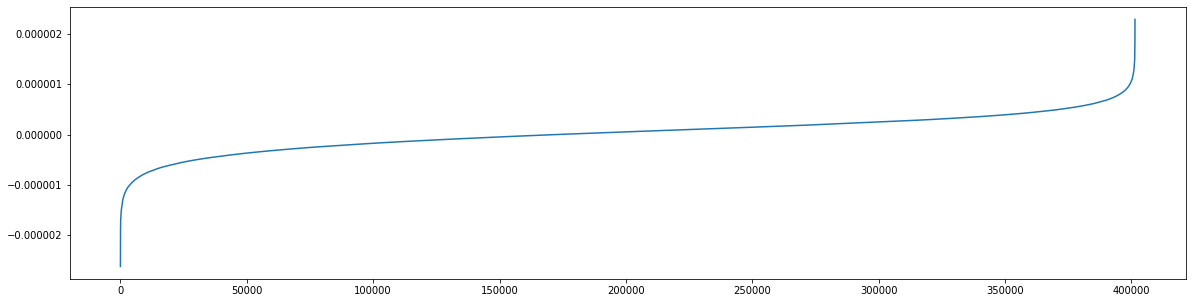

block5_pool


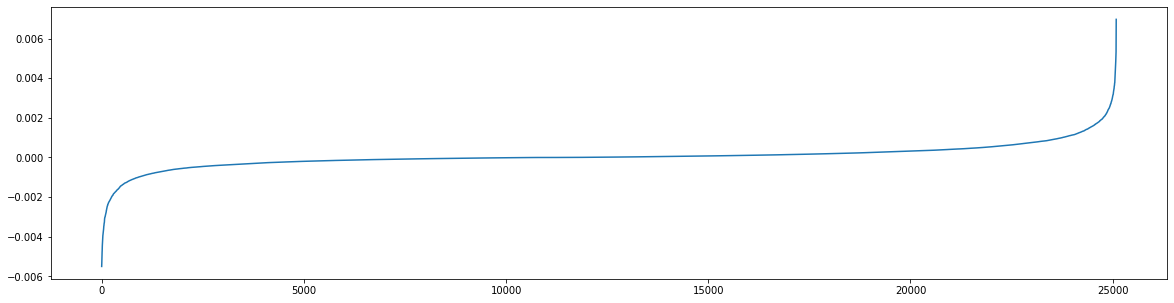

In [251]:
tcavs = {}
for key, value in zebra_fts_dict_VGG16.items():
    if len(value):
        count = 0
        value = np.array(value)
        value = value.reshape(no_imgs, -1)
        cav = get_direction(key, 'zebra_stripes')
        cav_sort = sorted(cav)
        print(key)
        plt.plot(cav_sort)
        plt.show()

In [252]:
# for each base image (zebra) feature, compute the directional derivative and get the TCAV score.

tcavs = {}
for key, value in zebra_fts_dict_VGG16.items():
    if len(value):
        count = 0
        value = np.array(value)
        value = value.reshape(no_imgs, -1)
        cav = get_direction(key, 'zebra_stripes')
        print("For layer # - ", key)
        for ft in value: # loop over every feature
            dydx = compute_direc_derivative(ft, cav)
            if dydx: count += 1
        tcav = float(count) / float(len(value))
        tcavs[key] = tcav

For layer # -  block2_pool
For layer # -  block5_pool


In [256]:
print(preds)

[]


In [253]:
print('Printing TCAV scores for each block!')
print(tcavs)

Printing TCAV scores for each block!
{'block2_pool': 0.5443037974683544, 'block5_pool': 0.8607594936708861}


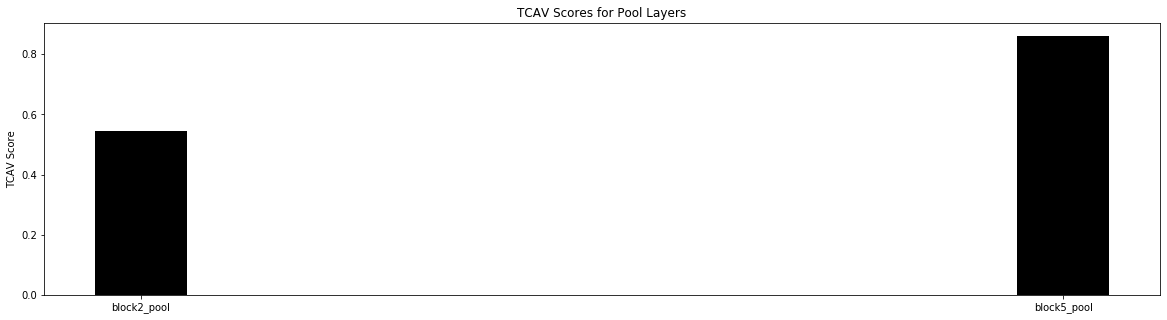

In [254]:
# Plot the TCAV scores
x_points = [x for x in range(len(tcavs.keys()))]
keys = list(tcavs.keys())
plt.bar(x_points, tcavs.values(), width=0.1, color='k')
plt.xticks(x_points, tcavs.keys())
plt.title('TCAV Scores for Pool Layers')
plt.ylabel('TCAV Score')
plt.show()

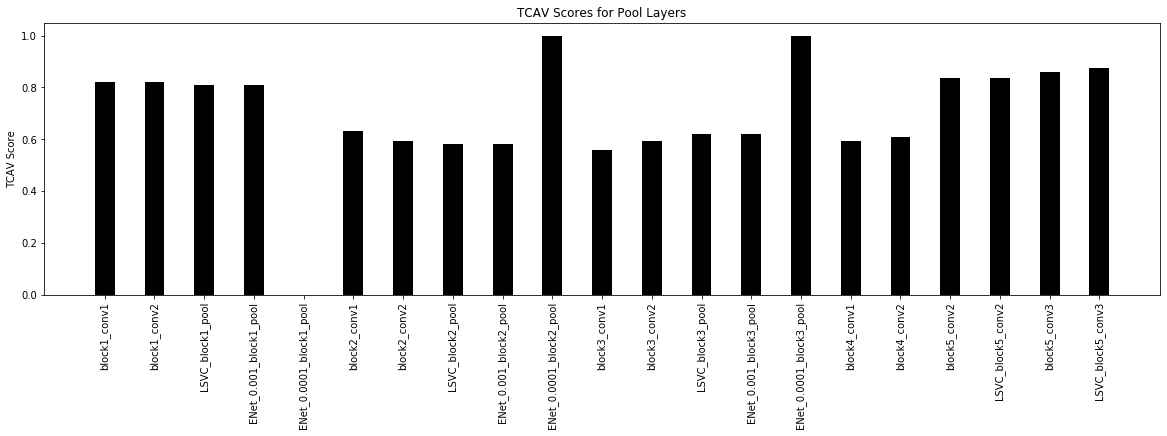

In [209]:
plot_scores = {
        
    "block1_conv1": 0.8227848101265823, 
    "block1_conv2": 0.8227848101265823,
    "LSVC_block1_pool": 0.810126582278481,
    "ENet_0.001_block1_pool": 0.810126582278481,
    "ENet_0.0001_block1_pool": 0.0,
    "block2_conv1": 0.6329113924050633,
    "block2_conv2": 0.5949367088607594,
    "LSVC_block2_pool": 0.5822784810126582, 
    "ENet_0.001_block2_pool": 0.5822784810126582, 
    "ENet_0.0001_block2_pool": 1.0,
    "block3_conv1": 0.5569620253164557, 
    "block3_conv2": 0.5949367088607594,
    "LSVC_block3_pool": 0.620253164556962,
    "ENet_0.001_block3_pool": 0.620253164556962,
    "ENet_0.0001_block3_pool": 1.0,
    "block4_conv1": 0.5949367088607594,
    "block4_conv2": 0.6075949367088608,
    "block5_conv2": 0.8354430379746836,
    "LSVC_block5_conv2": 0.8354430379746836,
    "block5_conv3": 0.8607594936708861,
    "LSVC_block5_conv3": 0.8734177215189873
}

x_points = [x for x in range(len(plot_scores.keys()))]
keys = list(plot_scores.keys())
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(x_points, plot_scores.values(), width=0.4, color='k')
plt.xticks(x_points, plot_scores.keys(), rotation=90)
plt.title('TCAV Scores for Pool Layers')
plt.ylabel('TCAV Score')
plt.show()